# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import torchvision.transforms as transforms

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("/content/GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### Imports

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

The following function is an auxiliary one created in order to avoid repeating parts of code every time.

In [ ]:
def get_data_loaders(train_transform, val_test_transform, batch_size=32):

    """
    Creating and returning the datasets as well as the loaders to use them in the code.

    Args:
        train_transform (callable): Transformation to be applied to the training dataset
        val_test_transform (callable): Transformation to be applied to validation and test datasets
        batch_size (int, optional): Number of samples per batch. Default is 32.

    Returns:
        train_dataset (Dataset): Dataset object for training data.
        val_dataset (Dataset): Dataset object for validation data.
        test_dataset (Dataset): Dataset object for testing data.
        train_loader (DataLoader): DataLoader for training dataset
        val_loader (DataLoader): DataLoader for validation dataset
        test_loader (DataLoader): DataLoader for test dataset
    """

    train_dataset = GroceryStoreDataset(split='train', transform=train_transform)
    val_dataset = GroceryStoreDataset(split='val', transform=val_test_transform)
    test_dataset = GroceryStoreDataset(split='test', transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

### Data preprocessing and augmentation
In this first step we transform both the train and the validation sets, this is done because we want to do some augmentation in order to reduce the bias of the network.
- at first the images are resized to 64x64 in order to ensure uniform input size
- then we have the data augmentation (of course, only for the training set) with RandomHorizontalFlip and RandomRotation
- finally we normalize the images

In [ ]:
# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
#define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#build dataset and loader
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_data_loaders(train_transform=train_transforms, val_test_transform=val_transforms)

### Plotting functions
Auxiliary functions which will be used to plot the results of the train and validation steps

In [ ]:
def plot_accuracy(train_acc, val_acc):

    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### Definition of training function
Here we define the training function. It takes as input the model, the train and val loader, as well as the criterion, optimizer, scheduler, number of epochs and patience. The total number of epoch is set to 20, although if there is no improvement after 5 steps the model stops training. These two values are predefined but they can be modified as needed when the function is called. At each epoch, we train on the train set and then evaluate the performance on the validation step.

In [ ]:
def train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    """
    Train the model on the training set and evaluate it on the validation set, with early stopping and a learning rate scheduler.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): Loss function used to calculate training and validation loss.
        optimizer (torch.optim.Optimizer): Optimizer for model weight updates.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler to adjust the learning rate during training.
        num_epochs (int, optional): Maximum number of training epochs. Default is 20.
        patience (int, optional): Number of epochs to wait in case we see no improvement. Default is 5.

    Returns:
        model (nn.Module): The trained model with the best weights (based on validation accuracy).
        train_loss_arr (list): List of training loss values for each epoch.
        train_acc_arr (list): List of training accuracy values for each epoch.
        val_loss_arr (list): List of validation loss values for each epoch.
        val_acc_arr (list): List of validation accuracy values for each epoch.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False

    train_loss_arr = []
    train_acc_arr = []
    val_loss_arr = []
    val_acc_arr = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_loss_arr.append(epoch_loss)
        train_acc_arr.append(epoch_acc)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Check if early stopping condition is met
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            early_stop = True
            break

        # Step the learning rate scheduler
        scheduler.step()

        print("-" * 20)

    # Restore best model weights
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr


### Definition of evaluation function
This function takes as input the model, the test loader and the criterion. It calculates the average test loss and the test accuracy by comparing the computed labels with the true ones.

In [ ]:
def evaluate_model_on_test_set(model, test_loader, criterion):
    """
    Evaluate the model on the test set.

    Args:
        model (nn.Module): Trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function to calculate test loss.

    Returns:
        test_loss (float): Average loss on the test set.
        test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    test_loss = test_loss / total_samples
    test_accuracy = test_corrects.double() / total_samples

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy


### Definition of loss function
In this class we define a variation of CrossEntropyLoss which also incorporates label smoothing, which is a regularization technique that adjusts the target labels during training by distributing a small portion of the target's "probability mass" to other classes.

In [ ]:
# Label Smoothing Cross Entropy Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        # Get number of classes
        num_classes = pred.size(1)

        # Create smoothed labels
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)

        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=1), dim=1))

### Definition of the network
The following is a CNN which uses 2d convolutions, with 64, 128, 256, 512 filters. We choose the convolutional layers because it was requested by the task assignment (aka, build a convolutional neural network). There is a total of four convolutional layers organized into two blocks. The activation function is ReLU.

We also use batch normalization and max pooling after the convolutional layers. Batch normalization is used specifically because it speeds up convergence and improves generalization.

Then instead of flattening we use a Global Average Pooling layer which summarizes each feature map into a single value.

We also use dropout, which is a regularization technique which randomly "switches off" some neurons in order to improve generalization and prevent the model to learn spurious correlations.

These techniques all reduce the chances of overfitting.

In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

        # Second convolutional block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))

        # Second block
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Training the model
As criterion we are using the **LabelSmoothingLoss** priorly defined, with smoothing parameter = 0.1. As an optimizer we are using **Adam**, which optimizes the model's weights in order to minimize the loss function. The parameter lr indicates the learning rate and sets the initial learning rate. Then the learning rate is adjusted via a scheduler, **StepLR** which dynamically adjusts the learning rate during training.

In [ ]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 2.8704 Acc: 0.2591
Validation Loss: 2.7837 Acc: 0.3446
--------------------
Epoch 2/30
Training Loss: 2.4175 Acc: 0.3845
Validation Loss: 2.7666 Acc: 0.3345
--------------------
Epoch 3/30
Training Loss: 2.2479 Acc: 0.4326
Validation Loss: 2.4259 Acc: 0.3851
--------------------
Epoch 4/30
Training Loss: 2.0710 Acc: 0.4920
Validation Loss: 2.4096 Acc: 0.4122
--------------------
Epoch 5/30
Training Loss: 1.9762 Acc: 0.5288
Validation Loss: 2.4542 Acc: 0.3514
--------------------
Epoch 6/30
Training Loss: 1.8497 Acc: 0.5723
Validation Loss: 2.3858 Acc: 0.4189
--------------------
Epoch 7/30
Training Loss: 1.7196 Acc: 0.6356
Validation Loss: 2.0738 Acc: 0.5068
--------------------
Epoch 8/30
Training Loss: 1.6621 Acc: 0.6701
Validation Loss: 2.2166 Acc: 0.5000
--------------------
Epoch 9/30
Training Loss: 1.6188 Acc: 0.6826
Validation Loss: 2.2832 Acc: 0.4966
--------------------
Epoch 10/30
Training Loss: 1.5438 Acc: 0.7125
Validation Loss: 2.0724 Acc: 0.5507


### Plots

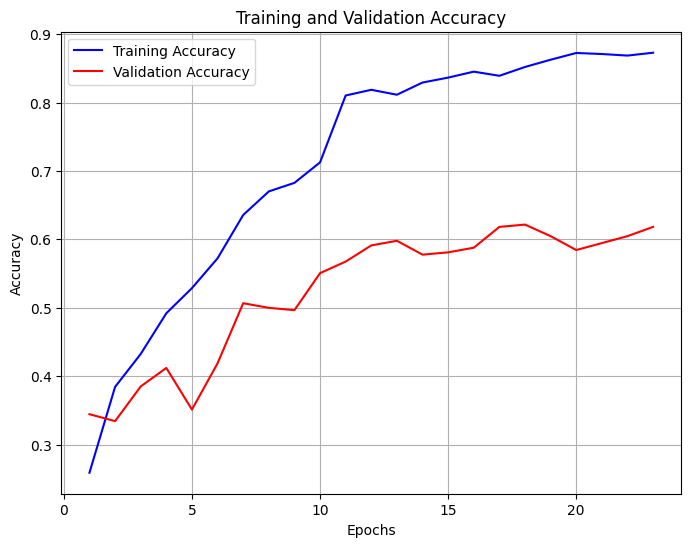

In [ ]:
plot_accuracy(train_acc_arr, val_acc_arr)

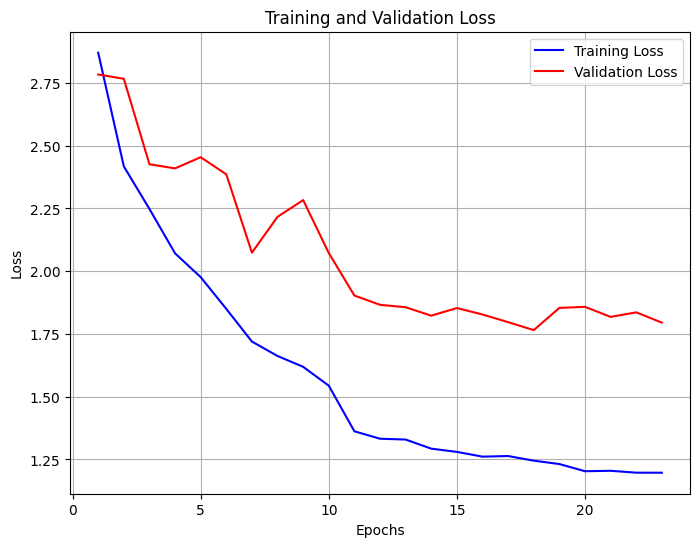

In [ ]:
plot_loss(train_loss_arr, val_loss_arr)

In [ ]:
model.load_state_dict(torch.load('best_grocery_cnn.pth'))
model.to(device)
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)

C:\Users\WIN11\AppData\Local\Temp\ipykernel_3684\1512604016.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_grocery_cnn.pth'))


Test Loss: 1.6319 | Test Accuracy: 0.6865


This proves that the defined network is able to achieve the expected results. Of course, these values are not high and there is still a lot more room for improvement, but they still satisfy the requirement defined in the task description.

### Ablation Study
We decided to follow the ablation study approach. This means that we take out components of this networks in order to see how the performance is affected by these choices. This allows to underline how each component affects the functioning of the network, and this proves that all the components we decided to insert in the network are necessary in order for it to work correctly.

*STEP 1* : remove one convolutional block

In [ ]:
class EnhancedCNN_v2(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v2(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model with early stopping
trained_model_v2, train_loss_arr_v2, train_acc_arr_v2, val_loss_arr_v2, val_acc_arr_v2 = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_v2.pth')


Epoch 1/30
Training Loss: 3.0322 Acc: 0.2273
Validation Loss: 2.9022 Acc: 0.2365
--------------------
Epoch 2/30
Training Loss: 2.6228 Acc: 0.3235
Validation Loss: 2.6174 Acc: 0.3311
--------------------
Epoch 3/30
Training Loss: 2.4427 Acc: 0.3811
Validation Loss: 2.6028 Acc: 0.3615
--------------------
Epoch 4/30
Training Loss: 2.3490 Acc: 0.4049
Validation Loss: 2.5186 Acc: 0.3345
--------------------
Epoch 5/30
Training Loss: 2.2689 Acc: 0.4295
Validation Loss: 2.4283 Acc: 0.4122
--------------------
Epoch 6/30
Training Loss: 2.1669 Acc: 0.4689
Validation Loss: 2.4327 Acc: 0.3716
--------------------
Epoch 7/30
Training Loss: 2.0884 Acc: 0.4943
Validation Loss: 2.5866 Acc: 0.3074
--------------------
Epoch 8/30
Training Loss: 2.0502 Acc: 0.5011
Validation Loss: 2.3134 Acc: 0.4527
--------------------
Epoch 9/30
Training Loss: 2.0163 Acc: 0.5148
Validation Loss: 2.3583 Acc: 0.4189
--------------------
Epoch 10/30
Training Loss: 1.9646 Acc: 0.5409
Validation Loss: 2.3213 Acc: 0.4291


We notice already a pretty big drop in performance

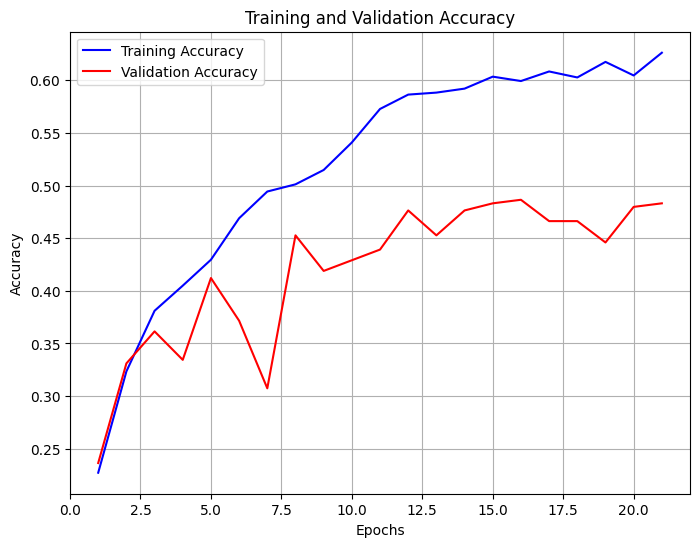

In [ ]:
plot_accuracy(train_acc_arr_v2, val_acc_arr_v2)

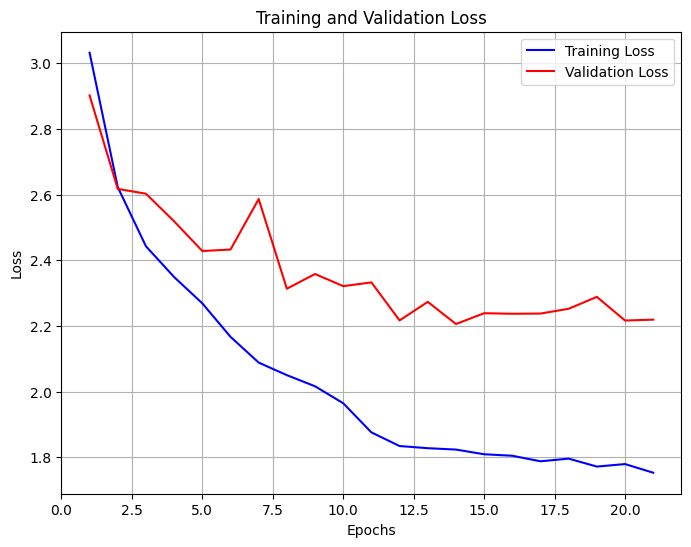

In [ ]:
plot_loss(train_loss_arr_v2, val_loss_arr_v2)

*STEP 2* : remove Batch Normalization

In [ ]:
class EnhancedCNN_v3(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v3(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model with early stopping
trained_model_v3, train_loss_arr_v3, train_acc_arr_v3, val_loss_arr_v3, val_acc_arr_v3 = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_v3.pth')


Epoch 1/30
Training Loss: 3.3000 Acc: 0.1538
Validation Loss: 3.1398 Acc: 0.2432
--------------------
Epoch 2/30
Training Loss: 2.8876 Acc: 0.2504
Validation Loss: 2.8563 Acc: 0.3041
--------------------
Epoch 3/30
Training Loss: 2.6817 Acc: 0.2966
Validation Loss: 2.7750 Acc: 0.3209
--------------------
Epoch 4/30
Training Loss: 2.4845 Acc: 0.3648
Validation Loss: 2.5805 Acc: 0.3142
--------------------
Epoch 5/30
Training Loss: 2.3762 Acc: 0.3917
Validation Loss: 2.5034 Acc: 0.3750
--------------------
Epoch 6/30
Training Loss: 2.2677 Acc: 0.4398
Validation Loss: 2.5108 Acc: 0.3108
--------------------
Epoch 7/30
Training Loss: 2.1791 Acc: 0.4833
Validation Loss: 2.4820 Acc: 0.3412
--------------------
Epoch 8/30
Training Loss: 2.0860 Acc: 0.4970
Validation Loss: 2.3837 Acc: 0.4155
--------------------
Epoch 9/30
Training Loss: 2.0306 Acc: 0.5223
Validation Loss: 2.4458 Acc: 0.3851
--------------------
Epoch 10/30
Training Loss: 1.9792 Acc: 0.5405
Validation Loss: 2.4458 Acc: 0.3750


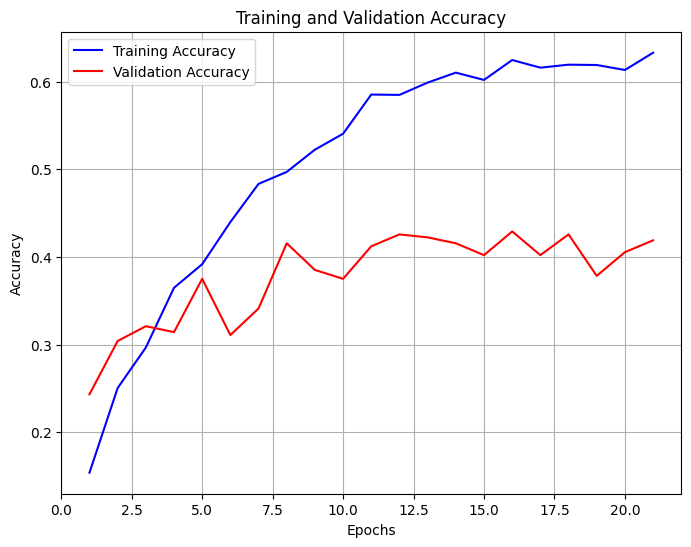

In [ ]:
plot_accuracy(train_acc_arr_v3, val_acc_arr_v3)

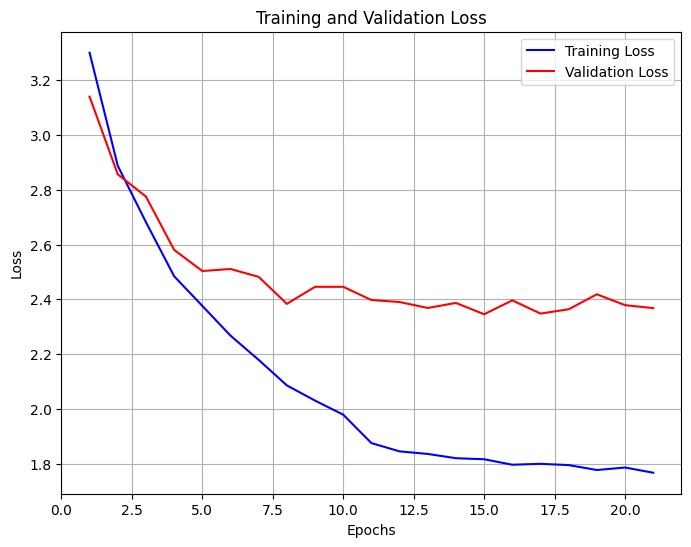

In [ ]:
plot_loss(train_loss_arr_v3, val_loss_arr_v3)

The performance drops again if this is done.

*STEP 3* : remove Global Average Pooling

In [ ]:
class EnhancedCNN_v4(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v4(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model with early stopping
trained_model_v4, train_loss_arr_v4, train_acc_arr_v4, val_loss_arr_v4, val_acc_arr_v4 = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_v4.pth')


Epoch 1/30
Training Loss: 5.3377 Acc: 0.1133
Validation Loss: 3.5774 Acc: 0.0608
--------------------
Epoch 2/30
Training Loss: 3.2290 Acc: 0.1795
Validation Loss: 3.3722 Acc: 0.1419
--------------------
Epoch 3/30
Training Loss: 3.0416 Acc: 0.2159
Validation Loss: 3.2831 Acc: 0.1216
--------------------
Epoch 4/30
Training Loss: 2.9363 Acc: 0.2439
Validation Loss: 3.2966 Acc: 0.1419
--------------------
Epoch 5/30
Training Loss: 2.8894 Acc: 0.2606
Validation Loss: 3.2547 Acc: 0.1419
--------------------
Epoch 6/30
Training Loss: 2.8540 Acc: 0.2667
Validation Loss: 3.2977 Acc: 0.1351
--------------------
Epoch 7/30
Training Loss: 2.8103 Acc: 0.2727
Validation Loss: 3.3161 Acc: 0.1318
Early stopping triggered
Best val Acc: 0.1419


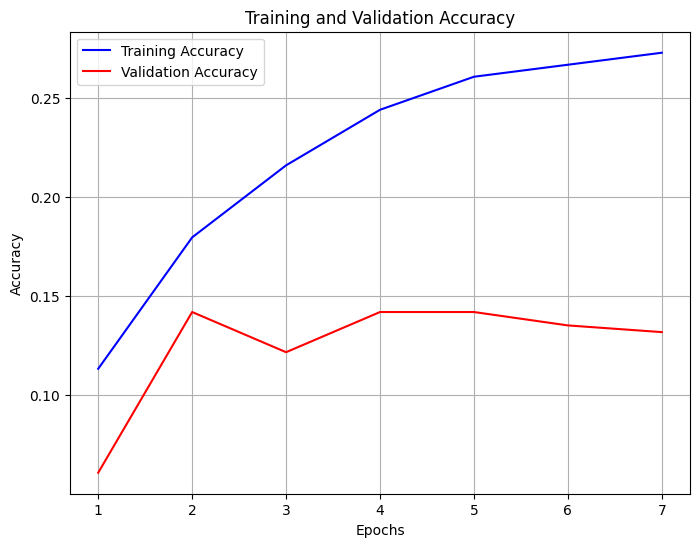

In [ ]:
plot_accuracy(train_acc_arr_v4, val_acc_arr_v4)

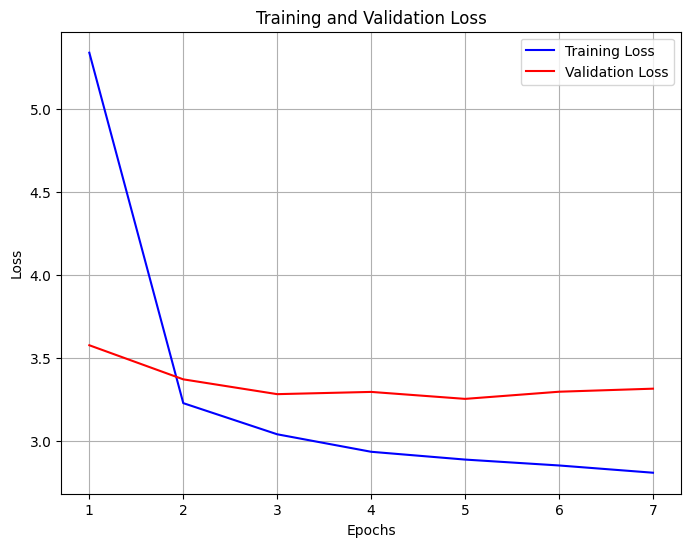

In [ ]:
plot_loss(train_loss_arr_v4, val_loss_arr_v4)

This completes the ablation study and shows how the first model I proposed brings the best results.

### Isolated step
In this last step, we check one more thing which goes to add value to the ablation study. We check if the main model (EnhancedCNN) performs as good with a simple CrossEntropyLoss instead of the LabelSmoothingLoss

In [ ]:
# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model with early stopping
trained_model_ce, train_loss_arr_ce, train_acc_arr_ce, val_loss_arr_ce, val_acc_arr_ce = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_ce.pth')


Epoch 1/30
Training Loss: 2.5646 Acc: 0.2761
Validation Loss: 2.3935 Acc: 0.3311
--------------------
Epoch 2/30
Training Loss: 2.0722 Acc: 0.3655
Validation Loss: 2.2683 Acc: 0.3547
--------------------
Epoch 3/30
Training Loss: 1.7599 Acc: 0.4390
Validation Loss: 2.1769 Acc: 0.3446
--------------------
Epoch 4/30
Training Loss: 1.6176 Acc: 0.4697
Validation Loss: 2.2652 Acc: 0.3209
--------------------
Epoch 5/30
Training Loss: 1.4386 Acc: 0.5205
Validation Loss: 1.9689 Acc: 0.3818
--------------------
Epoch 6/30
Training Loss: 1.3282 Acc: 0.5561
Validation Loss: 2.1100 Acc: 0.4020
--------------------
Epoch 7/30
Training Loss: 1.2222 Acc: 0.5985
Validation Loss: 2.1101 Acc: 0.4392
--------------------
Epoch 8/30
Training Loss: 1.1215 Acc: 0.6129
Validation Loss: 1.8916 Acc: 0.4764
--------------------
Epoch 9/30
Training Loss: 0.9911 Acc: 0.6583
Validation Loss: 1.9924 Acc: 0.4291
--------------------
Epoch 10/30
Training Loss: 0.9748 Acc: 0.6674
Validation Loss: 2.0457 Acc: 0.5169


This shows that with the CrossEntropyLoss the results we reach are not that distant from the ones obtained through the LabelSmoothingLoss, they still do not surpass the acceptable threshold.

### Further Exploration:
In this next part we thought about exploring a different type of model, which would exploit residual blocks instead of a double convolutional block. This second type of model should work better in deeper contexts or when dealing with bigger datasets, and they should improve generalization. They are also more complex and can be too much if the context is too simple. The fact that the previous model performs well even if it is more simple suggests that residual blocks may not be needed in this case, therefore this part is completely out of curiosity and to propose an alternative solution.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.batchnorm1(self.conv1(x)))
        out = self.batchnorm2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class ResBlockCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResBlockCNN, self).__init__()

        # First residual block
        self.res_block1 = ResidualBlock(3, 64, stride=1)
        self.res_block2 = ResidualBlock(64, 128, stride=2)

        # Second residual block
        self.res_block3 = ResidualBlock(128, 256, stride=2)
        self.res_block4 = ResidualBlock(256, 512, stride=2)

        # Global Average Pooling layer instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
num_classes = train_dataset.get_num_classes()
model = ResBlockCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model with early stopping
trained_model_res, train_loss_arr_res, train_acc_arr_res, val_loss_arr_res, val_acc_arr_res = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn_res.pth')


Epoch 1/30
Training Loss: 2.8642 Acc: 0.2811
Validation Loss: 2.9332 Acc: 0.2872
--------------------
Epoch 2/30
Training Loss: 2.4299 Acc: 0.3826
Validation Loss: 2.7895 Acc: 0.2804
--------------------
Epoch 3/30
Training Loss: 2.1998 Acc: 0.4504
Validation Loss: 2.6791 Acc: 0.3209
--------------------
Epoch 4/30
Training Loss: 2.1629 Acc: 0.4667
Validation Loss: 2.5537 Acc: 0.3818
--------------------
Epoch 5/30
Training Loss: 2.0190 Acc: 0.5178
Validation Loss: 2.8500 Acc: 0.3041
--------------------
Epoch 6/30
Training Loss: 1.9370 Acc: 0.5436
Validation Loss: 2.5405 Acc: 0.3615
--------------------
Epoch 7/30
Training Loss: 1.8466 Acc: 0.5742
Validation Loss: 2.3923 Acc: 0.3986
--------------------
Epoch 8/30
Training Loss: 1.8172 Acc: 0.5939
Validation Loss: 2.3042 Acc: 0.4662
--------------------
Epoch 9/30
Training Loss: 1.6840 Acc: 0.6424
Validation Loss: 2.4878 Acc: 0.3615
--------------------
Epoch 10/30
Training Loss: 1.6811 Acc: 0.6432
Validation Loss: 2.3712 Acc: 0.4155


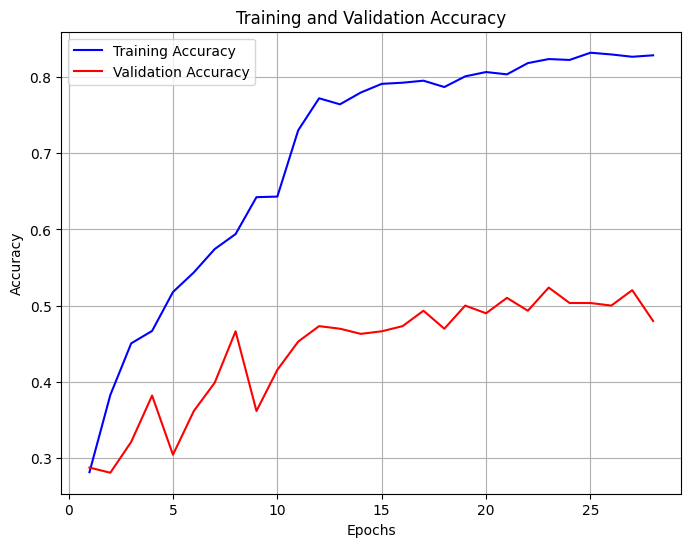

In [ ]:
plot_accuracy(train_acc_arr_res, val_acc_arr_res)

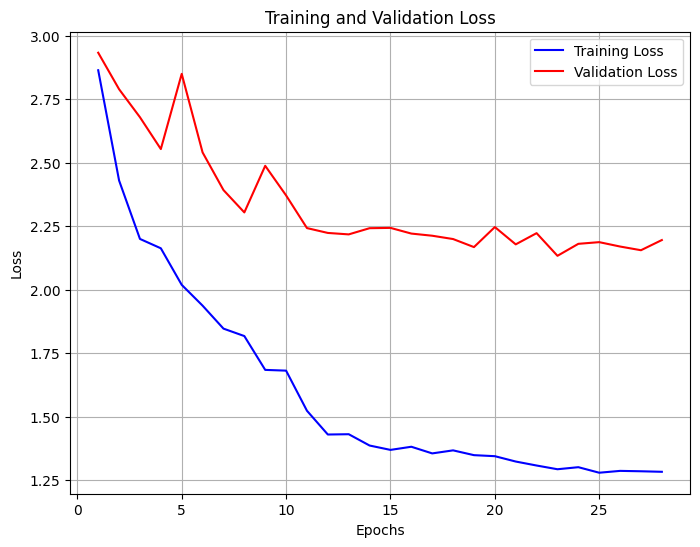

In [ ]:
plot_loss(train_loss_arr_res, val_loss_arr_res)

The results that this model yields are not good enough to be acceptable, which means that the residual blocks are not a good solution in this context. Also, we noticed that the training time drastically increases when computing this, meaning that the model is much too complex.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### Section 1: Fine-tune Resnet-18 with the same hyperparameters used for the best model in the 1st part of the assignment
- By using the same hyperparameters we achive a validation accuracy of 74.32% and test one of 75.25%

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import Tensor
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
def get_model():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    num_classes = train_dataset.get_num_classes()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
model = get_model().to(device)

for name, param in model.named_parameters():
    if 'fc' in name:  # If it's part of the fully connected layer
        param.requires_grad = True  # Keep it trainable
    else:
        param.requires_grad = False  # Freeze all other layers

In [ ]:
# The hyperparameters we have used for our best model
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 30
patience = 5

In [ ]:
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience
)

# Save the model
torch.save(trained_model.state_dict(), 'resnet18-v1.pth')

Epoch 1/30
Training Loss: 2.7567 Acc: 0.3663
Validation Loss: 2.3353 Acc: 0.4662
--------------------
Epoch 2/30
Training Loss: 1.7578 Acc: 0.6905
Validation Loss: 1.9223 Acc: 0.5878
--------------------
Epoch 3/30
Training Loss: 1.4391 Acc: 0.8121
Validation Loss: 1.7767 Acc: 0.6351
--------------------
Epoch 4/30
Training Loss: 1.2744 Acc: 0.8693
Validation Loss: 1.7062 Acc: 0.6723
--------------------
Epoch 5/30
Training Loss: 1.1947 Acc: 0.8981
Validation Loss: 1.6428 Acc: 0.6993
--------------------
Epoch 6/30
Training Loss: 1.1300 Acc: 0.9208
Validation Loss: 1.6455 Acc: 0.6791
--------------------
Epoch 7/30
Training Loss: 1.1052 Acc: 0.9280
Validation Loss: 1.6238 Acc: 0.6993
--------------------
Epoch 8/30
Training Loss: 1.0618 Acc: 0.9451
Validation Loss: 1.5607 Acc: 0.7230
--------------------
Epoch 9/30
Training Loss: 1.0475 Acc: 0.9462
Validation Loss: 1.5881 Acc: 0.7128
--------------------
Epoch 10/30
Training Loss: 1.0285 Acc: 0.9504
Validation Loss: 1.5741 Acc: 0.7365


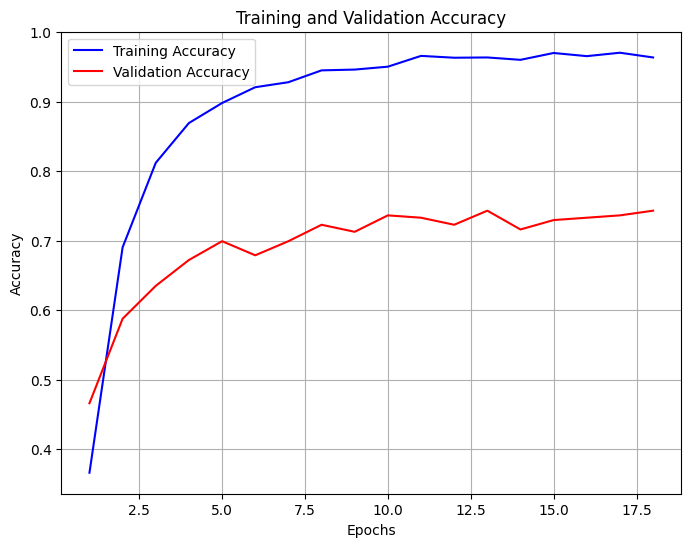

In [ ]:
plot_accuracy(train_acc_arr, val_acc_arr)

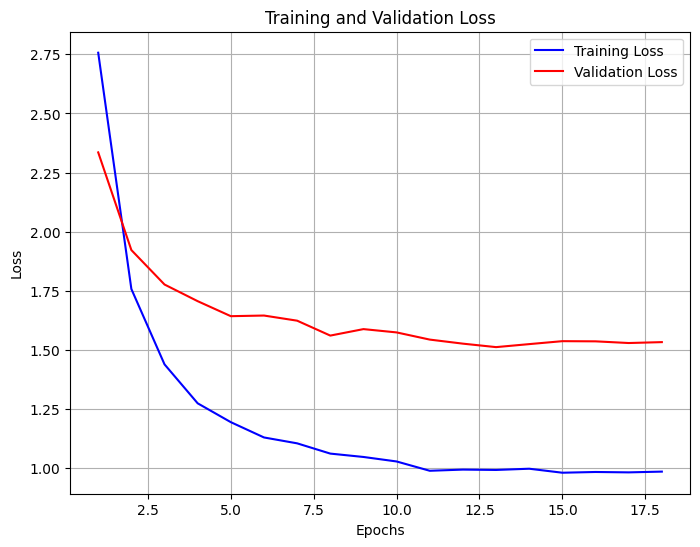

In [ ]:
plot_loss(train_loss_arr, val_loss_arr)

In [ ]:
# Load the trained model's state_dict
model.load_state_dict(torch.load('resnet18-v1.pth'))

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)


C:\Users\WIN11\AppData\Local\Temp\ipykernel_3684\1030581468.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18-v1.pth'))


Test Loss: 1.4658 | Test Accuracy: 0.7525


### Section 2: Tweak the training hyperparameters to increase the accuracy

Attempt 1:
1. Change the learning rate: higher for the final layer (1e-3) and lower for the pretrained layers (1e-4)
- Advantages of layer specific LR: lower layers usually capture general features, while higher task-specific. If we apply lower LR for the lower layers, we can preserve the general features. If we apply higher LR for the higher layers, we can help the model fine-tune more aggressively and adapt to the specifics. Information about this we found here: https://kharshit.github.io/blog/2019/03/22/layer-specific-learning-rates

2. Increase the patience

For this attempt we achieve 75.68% of validation accuracy, slightly better than before. The test one is 75.69%

In [ ]:
model = get_model().to(device)

for name, param in model.named_parameters():
    if 'fc' in name:  # If it's part of the fully connected layer
        param.requires_grad = True  # Keep it trainable
    else:
        param.requires_grad = False  # Freeze all other layers

In [ ]:
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},  # Higher LR for final layer
    {'params': model.layer4.parameters(), 'lr': 1e-4}])  # Lower LR for pretrained layers
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 30
patience = 10

In [ ]:
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience
)

# Save the model
torch.save(trained_model.state_dict(), 'resnet18-v2.pth')

Epoch 1/30
Training Loss: 2.6853 Acc: 0.3773
Validation Loss: 2.2782 Acc: 0.4561
--------------------
Epoch 2/30
Training Loss: 1.7432 Acc: 0.6970
Validation Loss: 1.9092 Acc: 0.5946
--------------------
Epoch 3/30
Training Loss: 1.4241 Acc: 0.8159
Validation Loss: 1.7869 Acc: 0.6047
--------------------
Epoch 4/30
Training Loss: 1.2749 Acc: 0.8754
Validation Loss: 1.6624 Acc: 0.6622
--------------------
Epoch 5/30
Training Loss: 1.1867 Acc: 0.9015
Validation Loss: 1.6271 Acc: 0.6993
--------------------
Epoch 6/30
Training Loss: 1.1287 Acc: 0.9155
Validation Loss: 1.6266 Acc: 0.6959
--------------------
Epoch 7/30
Training Loss: 1.0892 Acc: 0.9364
Validation Loss: 1.5651 Acc: 0.7331
--------------------
Epoch 8/30
Training Loss: 1.0608 Acc: 0.9405
Validation Loss: 1.5833 Acc: 0.7061
--------------------
Epoch 9/30
Training Loss: 1.0502 Acc: 0.9405
Validation Loss: 1.5982 Acc: 0.7095
--------------------
Epoch 10/30
Training Loss: 1.0321 Acc: 0.9470
Validation Loss: 1.5905 Acc: 0.7061


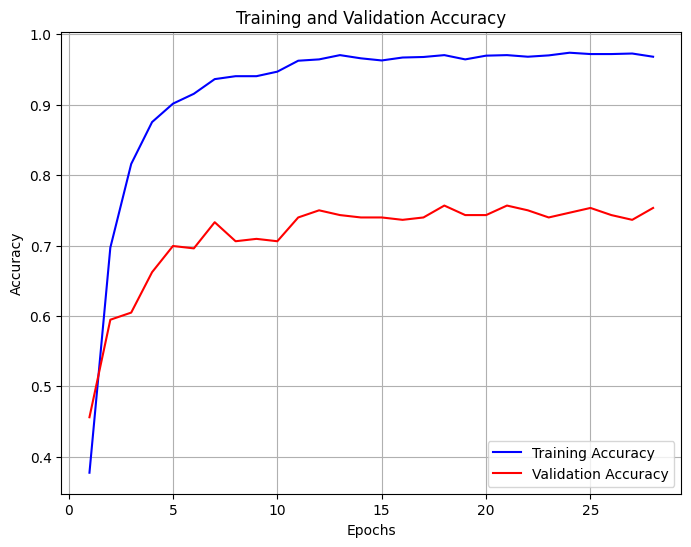

In [ ]:
plot_accuracy(train_acc_arr, val_acc_arr)

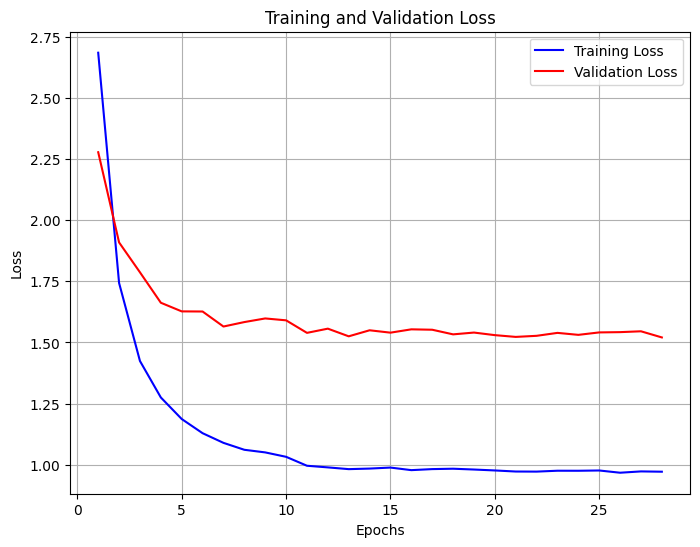

In [ ]:
plot_loss(train_loss_arr, val_loss_arr)

In [ ]:
# Load the trained model's state_dict
model.load_state_dict(torch.load('resnet18-v2.pth'))

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)


C:\Users\WIN11\AppData\Local\Temp\ipykernel_3684\1083324711.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18-v2.pth'))


Test Loss: 1.4672 | Test Accuracy: 0.7569


Attempt 2:
- Change the learning rate: higher learning rate for the final layer (1e-3), intermediate for higher layers (1e-4), lower for earlier layers (1e-5)
- In this attempt, we keep all the same apart from the learning rate. As in the previous attempt we just add specific LR for the different layers so that we capture and preserve the needed specific features and needs in the best way possible
- For this attempt we achieve validation accuracy of 76.69%, slightly better than before. The test one is 76.62%

In [ ]:
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},       # Higher learning rate for final layer
    {'params': model.layer4.parameters(), 'lr': 1e-4},   # Intermediate for higher layers
    {'params': model.layer3.parameters(), 'lr': 1e-5}    # Lower for earlier layers
])
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 30
patience = 10

In [ ]:

trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience
)

# Save the model
torch.save(trained_model.state_dict(), 'resnet18-v3.pth')

Epoch 1/30
Training Loss: 1.0064 Acc: 0.9527
Validation Loss: 1.5677 Acc: 0.7264
--------------------
Epoch 2/30
Training Loss: 1.0043 Acc: 0.9500
Validation Loss: 1.5629 Acc: 0.7331
--------------------
Epoch 3/30
Training Loss: 0.9753 Acc: 0.9678
Validation Loss: 1.5478 Acc: 0.7432
--------------------
Epoch 4/30
Training Loss: 0.9710 Acc: 0.9644
Validation Loss: 1.5940 Acc: 0.7128
--------------------
Epoch 5/30
Training Loss: 0.9654 Acc: 0.9659
Validation Loss: 1.5626 Acc: 0.7466
--------------------
Epoch 6/30
Training Loss: 0.9650 Acc: 0.9659
Validation Loss: 1.5843 Acc: 0.7162
--------------------
Epoch 7/30
Training Loss: 0.9487 Acc: 0.9716
Validation Loss: 1.5250 Acc: 0.7635
--------------------
Epoch 8/30
Training Loss: 0.9502 Acc: 0.9731
Validation Loss: 1.5788 Acc: 0.7365
--------------------
Epoch 9/30
Training Loss: 0.9416 Acc: 0.9750
Validation Loss: 1.5902 Acc: 0.7297
--------------------
Epoch 10/30
Training Loss: 0.9382 Acc: 0.9788
Validation Loss: 1.5379 Acc: 0.7534


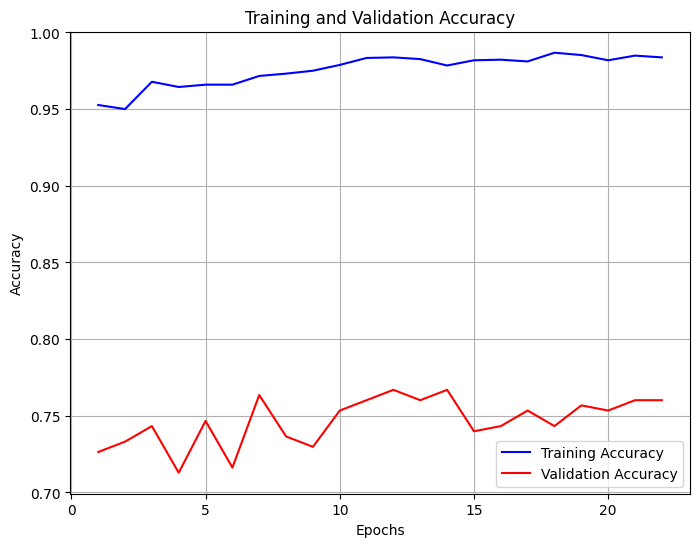

In [ ]:
plot_accuracy(train_acc_arr, val_acc_arr)

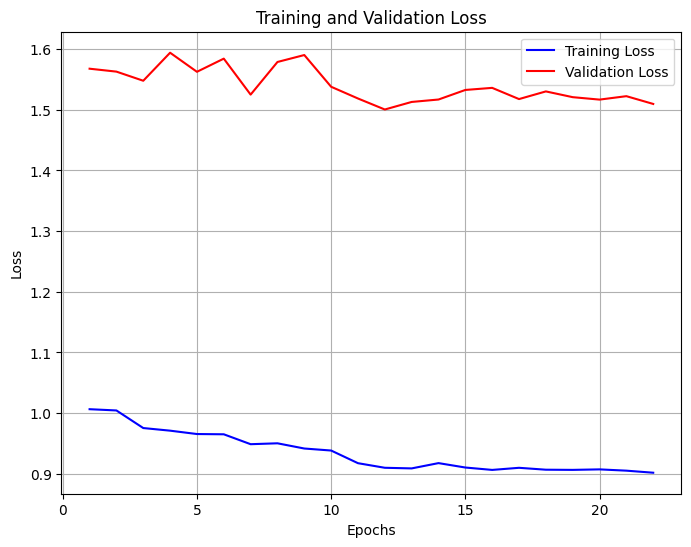

In [ ]:
plot_loss(train_loss_arr, val_loss_arr)

In [ ]:
# Load the trained model's state_dict
model.load_state_dict(torch.load('resnet18-v3.pth'))

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)


C:\Users\WIN11\AppData\Local\Temp\ipykernel_3684\2498083290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18-v3.pth'))


Test Loss: 1.4436 | Test Accuracy: 0.7662


Attempt 3:
1. Unfreeze all layers: to allow the model to fine-tune its entire feature-extraction pipeline
2. Change the step size and gamma for the scheduler:
- changing the step size to decay every 5 epochs instead of 10 to allow taking smaller steps earlier, which is benefitial for fine-tuning
- changing gamma from 0.1 to 0.5 will allow us ensure that the optimizer doesn't stagnate by decaying too slowly
3. Decrease the number of epochs

For this attempt we achieve validation accuracy of 88.51%, the test one is 87.12%

In [ ]:
model = get_model().to(device)
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers


In [ ]:
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},       # Higher learning rate for final layer
    {'params': model.layer4.parameters(), 'lr': 1e-4},   # Intermediate for higher layers
    {'params': model.layer3.parameters(), 'lr': 1e-5}    # Lower for earlier layers
])
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Decay LR more frequently for fine-tuning
num_epochs = 20
patience = 10


In [ ]:
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience
)
# Save the model
torch.save(trained_model.state_dict(), 'resnet18-v4.pth')

Epoch 1/20
Training Loss: 1.9149 Acc: 0.6527
Validation Loss: 1.6016 Acc: 0.6993
--------------------
Epoch 2/20
Training Loss: 0.9741 Acc: 0.9576
Validation Loss: 1.4041 Acc: 0.8007
--------------------
Epoch 3/20
Training Loss: 0.8483 Acc: 0.9879
Validation Loss: 1.3456 Acc: 0.8041
--------------------
Epoch 4/20
Training Loss: 0.8060 Acc: 0.9977
Validation Loss: 1.3213 Acc: 0.8176
--------------------
Epoch 5/20
Training Loss: 0.7848 Acc: 0.9989
Validation Loss: 1.3251 Acc: 0.8176
--------------------
Epoch 6/20
Training Loss: 0.7706 Acc: 0.9992
Validation Loss: 1.2865 Acc: 0.8378
--------------------
Epoch 7/20
Training Loss: 0.7646 Acc: 0.9996
Validation Loss: 1.2897 Acc: 0.8277
--------------------
Epoch 8/20
Training Loss: 0.7578 Acc: 0.9992
Validation Loss: 1.2901 Acc: 0.8446
--------------------
Epoch 9/20
Training Loss: 0.7597 Acc: 0.9992
Validation Loss: 1.2711 Acc: 0.8547
--------------------
Epoch 10/20
Training Loss: 0.7551 Acc: 1.0000
Validation Loss: 1.2814 Acc: 0.8412


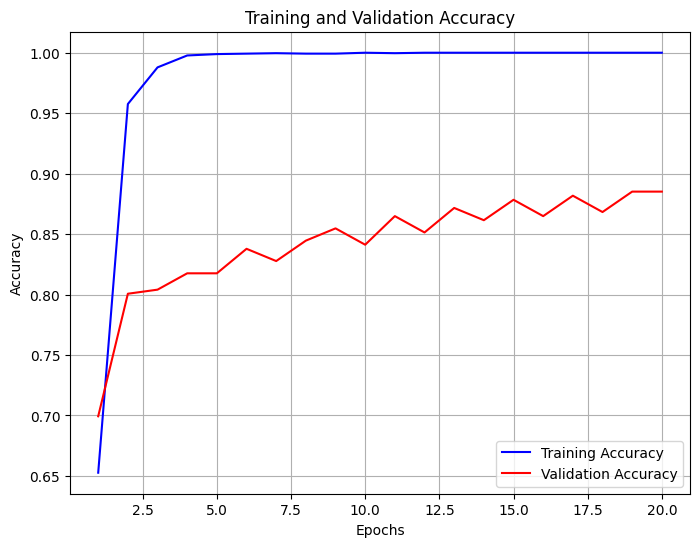

In [ ]:
plot_accuracy(train_acc_arr, val_acc_arr)

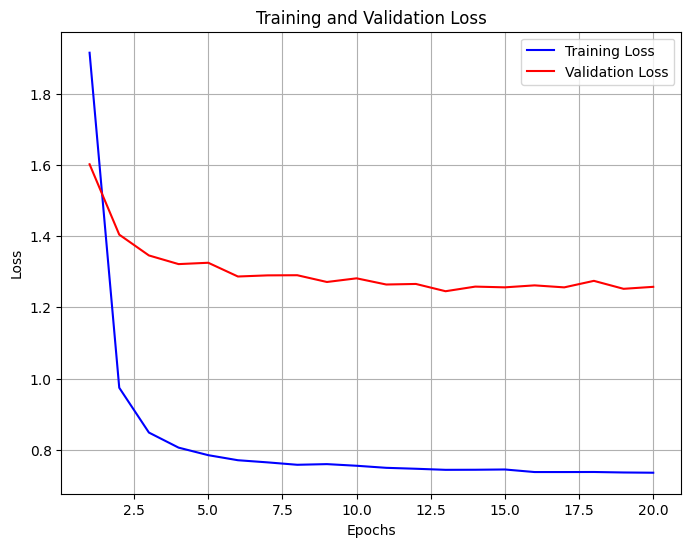

In [ ]:
plot_loss(train_loss_arr, val_loss_arr)

In [ ]:
# Load the trained model's state_dict
model.load_state_dict(torch.load('resnet18-v4.pth'))

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)


C:\Users\WIN11\AppData\Local\Temp\ipykernel_3684\93356977.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18-v4.pth'))


Test Loss: 1.1597 | Test Accuracy: 0.8712
